In [1]:
import remap
import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

## Load ST reference and scRNA-seq data
##### In this example, we used multiple ST captures as reference, where each capture represents a subregion of tissue, to reconstruct the pairwise distances of testing scRNA-seq cells and their cellular neighborhood clusters.
##### Source data can be downloaded from the link: https://drive.google.com/drive/folders/1X47bes5SLz1SIHw0YT99XlwkW53QaJij?usp=drive_link
##### For multi-capture training, we combined all ST captures into one anndata object, with a column in the adata.obs to indicate the source labels. In this data, ```Rdata.obs['source']``` indicates the capture ID.
##### The batch effect corrected expressions are stored in `Rdata.obsm['corrected']` and `Qdata.obsm['corrected']`. If no external batch correction is applied, setting `harmony = TRUE` in the `remap.Fit_cord_multi` function will run Harmony internally to remove batch effects.

In [2]:
Rdata = ad.read_h5ad("data/brain_hd_multi/st_data.h5ad")
Qdata = ad.read_h5ad("data/brain_hd_multi/sc_data.h5ad")
print(Rdata)
print(Qdata)

AnnData object with n_obs × n_vars = 26592 × 248
    obs: 'x_cord', 'y_cord', 'n_genes', 'n_counts', 'Cluster', 'source'
    var: 'gene_ids', 'feature_types', 'genome'
    obsm: 'corrected', 'covet', 'spatial'
AnnData object with n_obs × n_vars = 55823 × 12510
    obs: 'x_cord', 'y_cord', 'Cluster', 'n_genes', 'n_counts'
    var: 'n_cells'
    obsm: 'corrected', 'covet'


## Initialize neighboring gene-gene covariance estimation.
##### For multi-capture training, please add the parameter `batch_key = 'source'` to indicate the capture source label column.
##### After training, initialized neighboring gene-gene covariance for ST and scRNA-seq will be saved to `path_name` in `npy` format, named as `st_covariance.npy` and `sc_covariance.npy`.

In [3]:
data_name = "brain_hd_multi"
path_name =  f"remap_output/{data_name}"

Rdata, Qdata = remap.covet_init(st_data = Rdata, sc_data = Qdata, num_covet_genes=100, k_nearest=100, num_HVG=1000, batch_key = 'source',
                 save_path = path_name, covet_batch_size = None, log_input = 0.0, lib_size = False)

Loading precomputed neighboring gene-gene covariance


## Fit location prediction model.
##### We use `Fit_cord_multi` to train the prediction model with multiple ST captures. `equal_size` is a parameter to indicate whether each ST capture has equal size. If not, please change `equal_size=False`, and the locations of each ST capture will be rescaled by their location range.
##### For multi-capture training, please add the parameter `batch_key = 'source'` to indicate the capture source label column.
##### If the primary goal is to identify spatial neighbors and construct CN clusters/spatial niches, predicting the full pairwise distance matrix is often unnecessary. For each cell, only the pairwise distances of candidate neighbors will be predicted. In this case, please set `full_pairwise = False`.
##### The predicted pairwise distance will be saved to `path_name` in `npz` format.
##### If no external batch effect correction methods are applied, setting `harmony = True` is recommended to remove gene expression batch effect using Harmony

In [4]:
dist_pred = remap.Fit_cord_multi(Rdata = Rdata, location_data = Rdata.obs[['x_cord', 'y_cord']], Qdata = Qdata, path_name = path_name, 
                                 full_pairwise = False, neighbor_fraction=0.1,
                                 source_key = "source", equal_size = True, harmony = False)
print(dist_pred.shape)

Model is on GPU


/home/shunzhou/miniconda3/envs/remap_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Training, remap_rel: 100%|██████████████████████████████████| 500/500 [23:10<00:00,  2.78s/it, loss=0.1925]


Early stopping criteria reached.
Predicting pairwise distances for scRNA-seq data.


OpenBLAS warning: precompiled NUM_THREADS exceeded, adding auxiliary array for thread metadata.
To avoid this warning, please rebuild your copy of OpenBLAS with a larger NUM_THREADS setting
or set the environment variable OPENBLAS_NUM_THREADS to 128 or lower
100%|████████████████████████████████████████████████████████████████| 38031/38031 [40:43<00:00, 15.57it/s]


(55823, 55823)


In [5]:
from scipy.sparse import load_npz

dist_pred = load_npz(f"{path_name}/remap_rel_dist.npz")
dist_pred = dist_pred.A
dist_pred[dist_pred == 0] = np.inf

## Cellular Neighborhood (CN) clustering and network construction
##### Performed CN clustering based on predicted pairwise distance matrix. Here, cells were plotted under true locations and colored by ground-truth or predicted CN clusters.

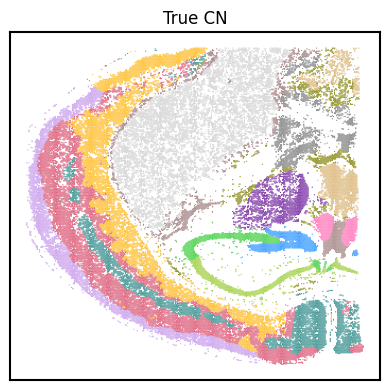

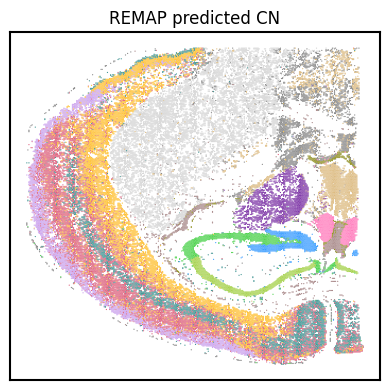

In [6]:
knn = 100
n_clust = 15

Qdata.obsm['spatial'] = np.array(Qdata.obs[['x_cord', 'y_cord']])
cn_true = remap.cn_cluster(Qdata.obs, Qdata.obs[['x_cord', 'y_cord']], ct_key = "Cluster", n_clust=n_clust, knn=knn)
cn_remap = remap.cn_cluster(Qdata.obs, dist_pred, ct_key = "Cluster", n_clust=n_clust, knn=knn)
Qdata.obs['CN_true'] = cn_true
Qdata.obs['CN_remap'] = cn_remap

colors = {'1': '#268785', '2': '#997273', '3': '#808000', '4': '#FEB915', '5': '#32CD32',
          '6': '#9E7A7A', '7': '#6D1A9C', '8': '#DAB370', '9': '#C798EE', '10': '#D1D1D1', 
          '11': '#787878', '12': '#1E90FF', '13': '#9ACD32', '14': '#FF69B4', '15': '#DB4C6C'}

## To find the rough matching between two sets of CN clusters, so that their colors are matched. Only for visualization.
cluster_corr = remap.match_clusters(Qdata.obs, key_ref = 'CN_true', key_new = 'CN_remap')
## {remap_clust: true_clust}
colors_remap = pd.Series(colors).rename(index={v: k for k, v in cluster_corr.items()}).to_dict()

remap.scatter_plot(Qdata, colors, spatial_key = "spatial", cluster_key = "CN_true", s = 0.75, title = "True CN")
remap.scatter_plot(Qdata, colors_remap, spatial_key = "spatial", cluster_key = "CN_remap", s = 0.75, title = "REMAP predicted CN")

##### NMI between ground-truth and predicted CN cluster labels

In [7]:
from sklearn.metrics import normalized_mutual_info_score
normalized_mutual_info_score(cn_true, cn_remap)

0.6716514561936826

##### Optionally, we can use Multi-dimensional scaling (MDS) to recover the 2D embeddings from the predicted pairwise distance matrix. For example, we extracted clusters belonging to hippocampus region and do MDS based on predicted pairwise distance matrix. Here, since the primary goal is to reconstruct the 2D embeddings, the full pairwise distance matrix is required, and please set `full_pairwise = True`

100%|████████████████████████████████████████████████████████████████████████████████| 616/616 [00:40<00:00, 15.06it/s]


0.5720736582095617


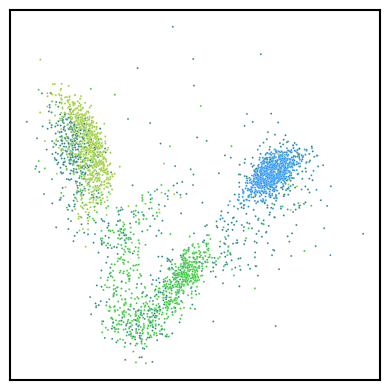

In [ ]:
Qdata_hippo = Qdata[Qdata.obs['Cluster'].isin(['14', '20', '22', '23'])].copy()

dist_hippo = remap.Prefict_cord_rel(Rdata, Qdata_hippo, path_name, full_pairwise = True, filename = "dist_hippo")
remap.pair_corr_rel(Qdata_hippo.obs[['x_cord', 'y_cord']], dist_hippo)

mds_hippo = remap.MDSTransform(dist_hippo)
# mds_hippo = remap.MDSalign(Qdata_hippo.obs[['x_cord', 'y_cord']], mds_hippo)
Qdata_hippo.obsm['remap'] = mds_hippo
colors = {'14': '#268785', '20': '#32CD32', '22': '#9ACD32', '23': '#1E90FF'}
remap.scatter_plot(Qdata_hippo, colors, spatial_key = "remap", cluster_key = "Cluster", s = 2)